In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
df = !ls "/content/drive/My Drive/real_estate.csv"

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64
(414, 8)


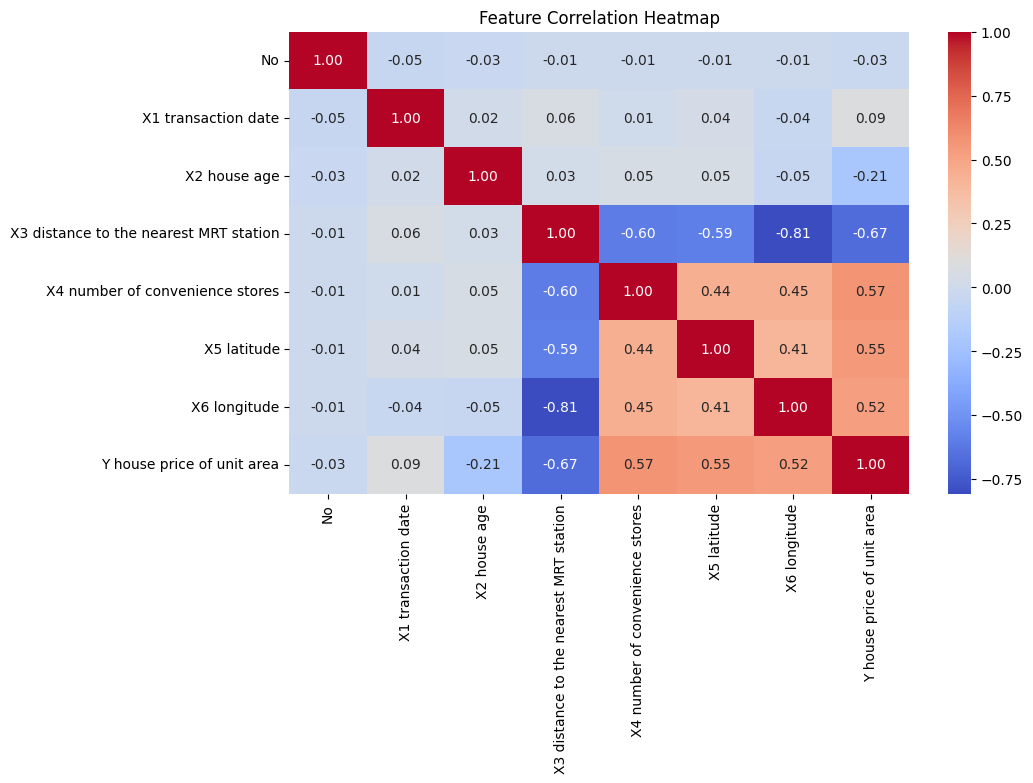

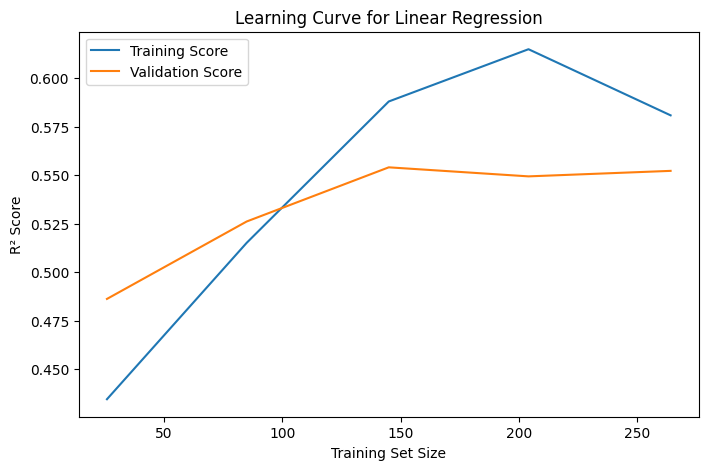

In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/My Drive/real_estate.csv")

# Check for missing values
print(df.isnull().sum())
print(df.shape)

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Selecting features based on correlation analysis
features = ['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']

# Log transform 'X3 distance to MRT station' to normalize skewness
df['X3 distance to the nearest MRT station'] = np.log1p(df['X3 distance to the nearest MRT station'])

X = df[features]
y = df['Y house price of unit area']

# Splitting dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data for Ridge and Lasso regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### LINEAR REGRESSION ###
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# Learning Curve for Linear Regression (Detecting Underfitting)
train_sizes, train_scores, val_scores = learning_curve(linear_reg, X_train, y_train, cv=5, scoring='r2')
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, val_mean, label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Learning Curve for Linear Regression")
plt.show()



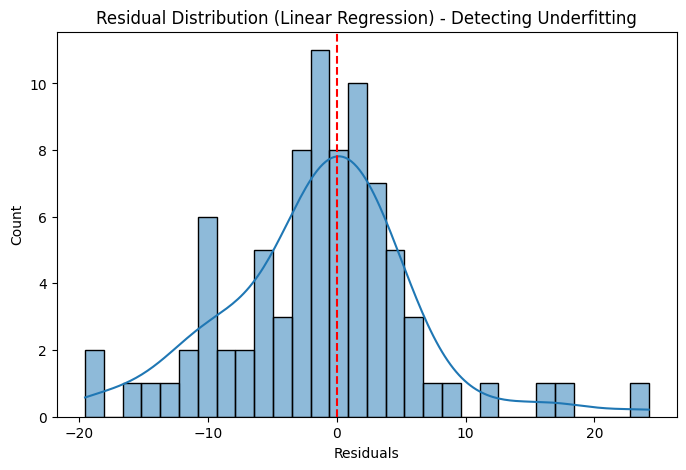


Lasso Regression Feature Coefficients:
X3 distance to the nearest MRT station   -7.839512
X4 number of convenience stores           0.624244
X5 latitude                               3.388163
X6 longitude                              0.052371
dtype: float64
Linear Regression - RMSE: 7.375, R²: 0.676
Ridge Regression  - RMSE: 7.372, R²: 0.676
Lasso Regression  - RMSE: 7.380, R²: 0.675
Random Forest  - RMSE: 6.122, R²: 0.777
XGBoost Regression - RMSE: 5.879, R²: 0.794


<Figure size 800x500 with 0 Axes>

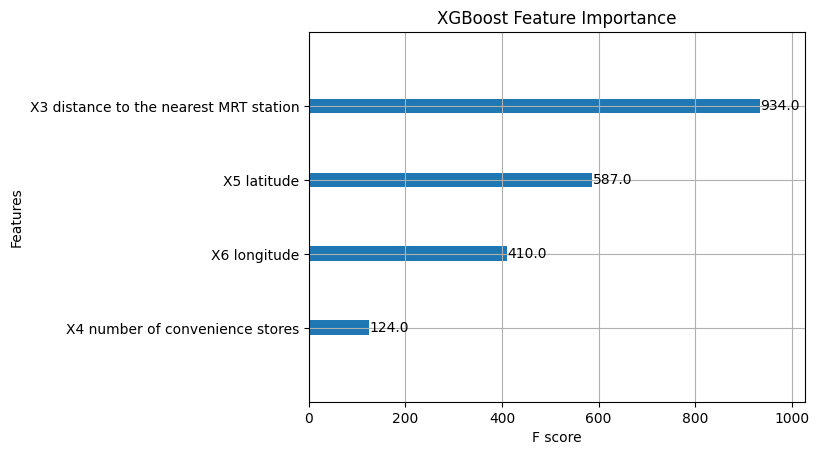

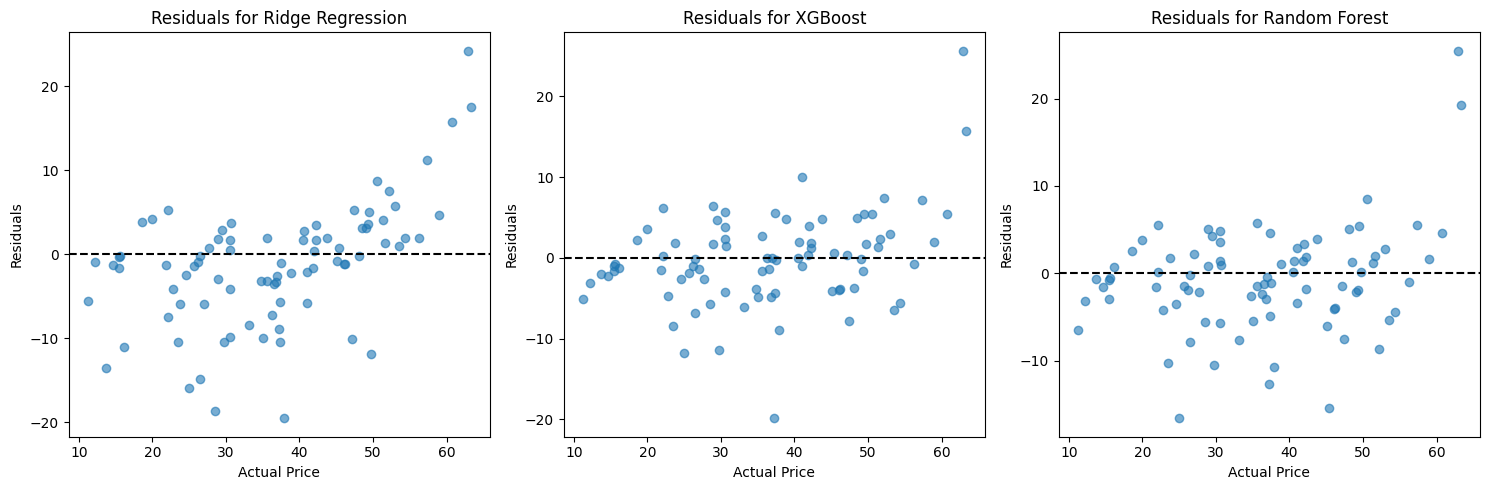

In [ ]:
# Residual Distribution for Linear Regression
plt.figure(figsize=(8, 5))
sns.histplot(y_test - y_pred_lr, bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution (Linear Regression) - Detecting Underfitting")
plt.xlabel("Residuals")
plt.show()

### RIDGE REGRESSION ###
ridge_reg = Ridge(alpha=0.5)  # Optimized alpha
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

### LASSO REGRESSION (Feature Selection - Removing 'Latitude') ###
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Checking which features Lasso removed
lasso_coeffs = pd.Series(lasso_reg.coef_, index=features)
print("\nLasso Regression Feature Coefficients:")
print(lasso_coeffs)

### RANDOM FOREST REGRESSION ###
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

### XGBOOST REGRESSION ###
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

### MODEL COMPARISON ###
print(f"Linear Regression - RMSE: {rmse_lr:.3f}, R²: {r2_lr:.3f}")
print(f"Ridge Regression  - RMSE: {rmse_ridge:.3f}, R²: {r2_ridge:.3f}")
print(f"Lasso Regression  - RMSE: {rmse_lasso:.3f}, R²: {r2_lasso:.3f}")
print(f"Random Forest  - RMSE: {rmse_rf:.3f}, R²: {r2_rf:.3f}")
print(f"XGBoost Regression - RMSE: {rmse_xgb:.3f}, R²: {r2_xgb:.3f}")

# Feature Importance for XGBoost
plt.figure(figsize=(8, 5))
xgb.plot_importance(xgb_reg)
plt.title("XGBoost Feature Importance")
plt.show()

# Residual Plot (Ridge vs XGBoost vs Random Forest)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test - y_pred_ridge, alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals for Ridge Regression")
plt.xlabel("Actual Price")
plt.ylabel("Residuals")

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test - y_pred_xgb, alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals for XGBoost")
plt.xlabel("Actual Price")
plt.ylabel("Residuals")

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test - y_pred_rf, alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals for Random Forest")
plt.xlabel("Actual Price")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()
